# Install or upgrade libraries

It might be that you are running with the latest libraries and that they all work together fine. 

Running the following cell takes a minute or so but ensures that you have a consistent set of python tools. 

In [1]:
import sys
print(f"{sys.version = }\n")


sys.version = '3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:23:25) [GCC 13.3.0]'



In [2]:
# If there are issues with fsspect-xrootd not being found, run this outside of Jupyter-notebook and restart
# !pip install --upgrade fsspec-xrootd

In [3]:
#'''
!pip install --upgrade pip

!pip install futures 

!pip install --user --upgrade coffea

!pip install --upgrade awkward
!pip install --upgrade uproot

!pip install --upgrade fsspec-xrootd

!pip install vector

!pip install --upgrade pandas


!pip install --upgrade matplotlib
#'''

We've also prepared some helper code that makes it easier to work with the data in this lesson.

You can see the code [here](https://github.com/cms-opendata-workshop/workshop2024-lesson-event-selection/blob/main/instructors/dpoa_workshop_utilities.py) but we will explain the functions and data objects in this notebook. 

Let's download it first. 

In [4]:
!wget https://raw.githubusercontent.com/cms-opendata-workshop/workshop2024-lesson-event-selection/main/instructors/dpoa_workshop_utilities.py

--2025-06-05 10:42:52--  https://raw.githubusercontent.com/cms-opendata-workshop/workshop2024-lesson-event-selection/main/instructors/dpoa_workshop_utilities.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9657 (9.4K) [text/plain]
Saving to: ‘dpoa_workshop_utilities.py.2’

dpoa_workshop_utili 100%[===================>]   9.43K  --.-KB/s    in 0s      

2025-06-05 10:42:52 (37.4 MB/s) - ‘dpoa_workshop_utilities.py.2’ saved [9657/9657]



## Imports

Import all the libraries we will need and check their versions, in case you run into issues. 

In [5]:
%load_ext autoreload
%autoreload 2

# The classics
import numpy as np
import matplotlib.pylab as plt
import matplotlib # To get the version

import pandas as pd

# The newcomers
import awkward as ak
import uproot

import vector
vector.register_awkward()

import requests
import os

import time

import json

import dpoa_workshop_utilities
from dpoa_workshop_utilities import nanoaod_filenames
from dpoa_workshop_utilities import get_files_for_dataset
from dpoa_workshop_utilities import pretty_print
from dpoa_workshop_utilities import build_lumi_mask

import sys

In [6]:
print("Versions --------\n")
print(f"{sys.version = }\n")
print(f"{ak.__version__ = }\n")
print(f"{uproot.__version__ = }\n")
print(f"{np.__version__ = }\n")
print(f"{matplotlib.__version__ = }\n")
print(f"{vector.__version__ = }\n")
print(f"{pd.__version__ = }\n")

Versions --------

sys.version = '3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:23:25) [GCC 13.3.0]'

ak.__version__ = '2.8.3'

uproot.__version__ = '5.6.2'

np.__version__ = '1.26.4'

matplotlib.__version__ = '3.10.3'

vector.__version__ = '1.6.2'

pd.__version__ = '2.3.0'



# Opening a file

Let's open and explore a sample file. 

We'll be getting the data from [here](https://opendata.cern.ch/record/67993).

This is some Monte Carlo that contains simulations of a top-antitop pair being created in a proton-proton collision at CMS. 

One top decays leptonically and the other decays hadronically. 

**Do you know what leptonically and hadronically mean? If not, do a bit of research.**

When you go to open the file, it might take 10-30 seconds at this step if you are working with the larger file.

In [7]:
# For testing
# Big file
#filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'

# Smaller file, better for prototyping your code as things will run faster
filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root'

print(f"Opening...{filename}")
f = uproot.open(filename)

events = f['Events']

nevents = events.num_entries

print(f"{nevents = }")

Opening...root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root
nevents = 168000


In [47]:
def load_file(size):
    '''
    size = "big" or "small"
    '''
    if size == "big": 
        # Big file
        filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'
    elif size == "small":
        # Smaller file, better for prototyping your code as things will run faster
        filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root'

    print(f"Opening...{filename}")
    f = uproot.open(filename)

    events = f['Events']

    nevents = events.num_entries

    print(f"{nevents = }")
        

The `events` object is a `TTree` implementation in python and behaves like a dictionary. This means 
we can get all the keys if we want. 

In [8]:
# Uncomment the following line to print all the keys

#print(events.keys())

Again, we have provided you with a helper function called `pretty_print` that will print subsets of the keys, based on strings
that you require or ignore. 

It will also format that output based on how many characters you want in a column (you are limited to 80 characters per line). 

Here is some example usage. 

In [9]:
# Pretty print all the keys with the default format
#pretty_print(events.keys())

# Pretty print keys with 30 characters per column, for keys that contain `FatJet`
#pretty_print(events.keys(), fmt='30s', require='FatJet')

# Pretty print keys with 40 characters per column, for keys that contain `Muon` and `Iso` but ignore ones with `HLT`
#pretty_print(events.keys(), fmt='40s', require=['Muon', 'Iso'], ignore='HLT')

# Pretty print keys with 40 characters per column, for keys that contain `HLT` and `TkMu50`
#pretty_print(events.keys(), fmt='40s', require=['HLT', 'TkMu50'])

# Pretty print keys with 40 characters per column, for keys that contain `HLT`
#pretty_print(events.keys(), fmt='40s', require='HLT')

# Pretty print keys with 40 characters per column, for keys that contain `Jet_` but ignore ones with `Fat`
pretty_print(events.keys(), fmt='40s', require='Jet_', ignore='Fat')

# Pretty print keys with 40 characters per column, for keys that contain `PuppiMET` but ignore ones with `Raw`
#pretty_print(events.keys(), fmt='40s', require='PuppiMET', ignore='Raw')

CorrT1METJet_area                        CorrT1METJet_eta                         
CorrT1METJet_muonSubtrFactor             CorrT1METJet_phi                         
CorrT1METJet_rawPt                       GenJet_eta                               
GenJet_mass                              GenJet_phi                               
GenJet_pt                                Jet_area                                 
Jet_btagCSVV2                            Jet_btagDeepB                            
Jet_btagDeepCvB                          Jet_btagDeepCvL                          
Jet_btagDeepFlavB                        Jet_btagDeepFlavCvB                      
Jet_btagDeepFlavCvL                      Jet_btagDeepFlavQG                       
Jet_chEmEF                               Jet_chFPV0EF                             
Jet_chHEF                                Jet_eta                                  
Jet_hfsigmaEtaEta                        Jet_hfsigmaPhiPhi                        
Jet_

## Extract some data

We're going to pull out subsets of the data in order to do our analysis. 

As a reminder, you can find a list of the variable names in each dataset on the CERN Open Data Portal page for that dataset, for example, [here](https://opendata.cern.ch/eos/opendata/cms/dataset-semantics/NanoAODSIM/75156/ZprimeToTT_M2000_W20_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8_doc.html).

We're going to work with the following sets of variables
* `FatJet` for jets that are merges
* `Jet` for non-merged jets
* `Muon` for muons
* `PuppiMET` which is missing energy in the transverse plane (MET) for pileup per particle identification (Puppi)

Running this cell might take a little bit if you are running over the bigger file. However, once you pull out the values, later calculations are much faster. 

In [25]:
# Jets ---------------------------------------------------
# B-tagging variable
jet_btagB = events['Jet_btagDeepB'].array()
jet_btagFlavB = events ['Jet_btagDeepFlavB'].array()

# Measure of quality of measurement of jet
jet_jetid = events['Jet_jetId'].array()

# 4-momentum in pt, eta, phi, mass 
jet_pt = events['Jet_pt'].array()
jet_eta = events['Jet_eta'].array()
jet_phi = events['Jet_phi'].array()
jet_mass = events['Jet_mass'].array()


# Muons ---------------------------------------------------
# Muon isolation
muon_iso = events['Muon_miniIsoId'].array()

# Measure of quality of how well the muon is reconstructed
muon_tightId = events['Muon_tightId'].array()

# 4-momentum in pt, eta, phi, mass 
muon_pt = events['Muon_pt'].array()
muon_eta = events['Muon_eta'].array()
muon_phi = events['Muon_phi'].array()
muon_mass = events['Muon_mass'].array()


# MET ------------------------------------------------------
# 3-momentum in pt, eta, phi, mass 
met_pt = events['PuppiMET_pt'].array()
met_eta = 0*events['PuppiMET_pt'].array()  # Fix this to be 0
met_phi = events['PuppiMET_phi'].array() 

# What comes next?  

## Basic Plots

- Simple Muon Cuts (pt > cut)
- Simpe Jet Cuts (pt > cut)
- The B-tag cut (DeepB > tight, medium, loose)

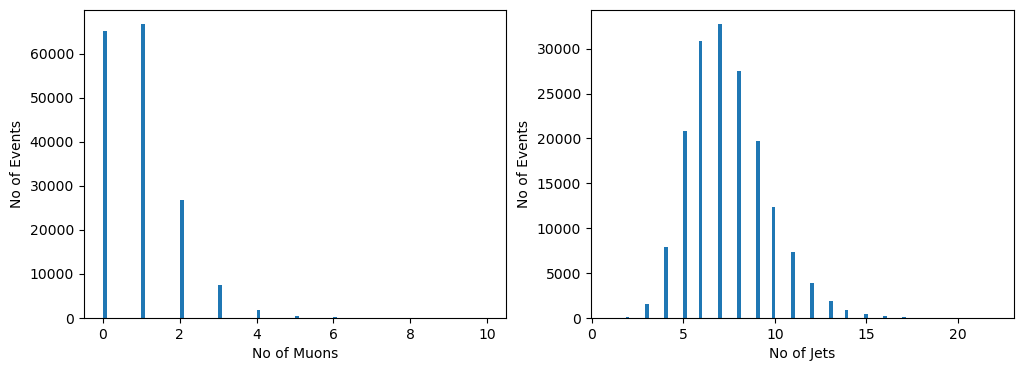

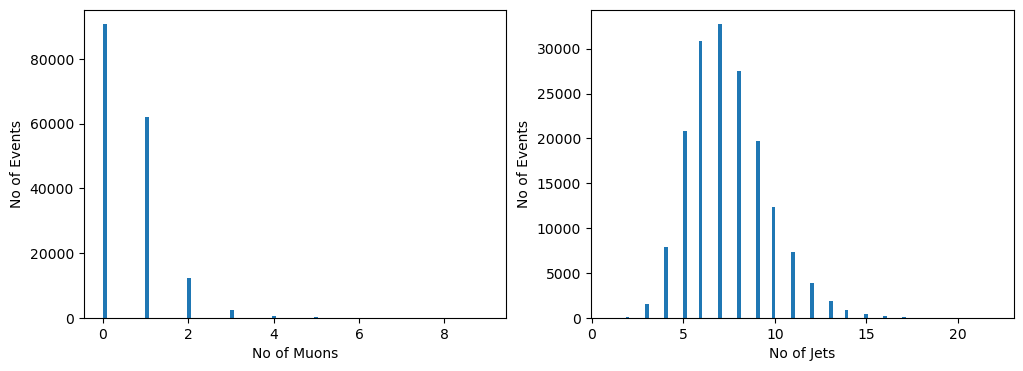

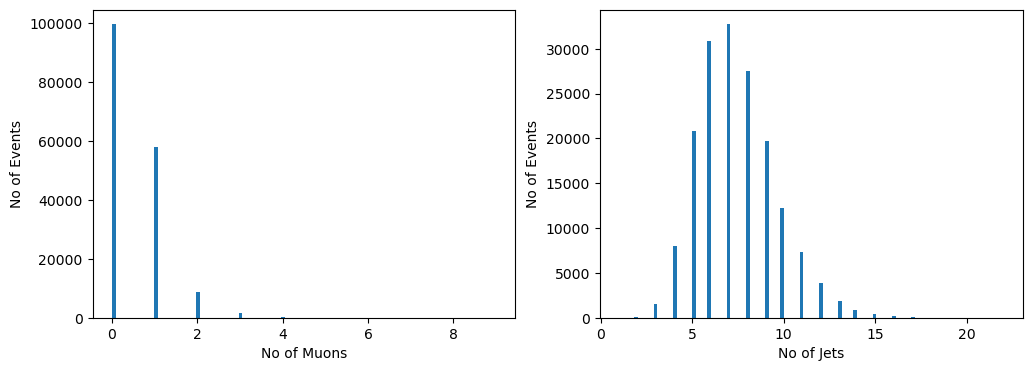

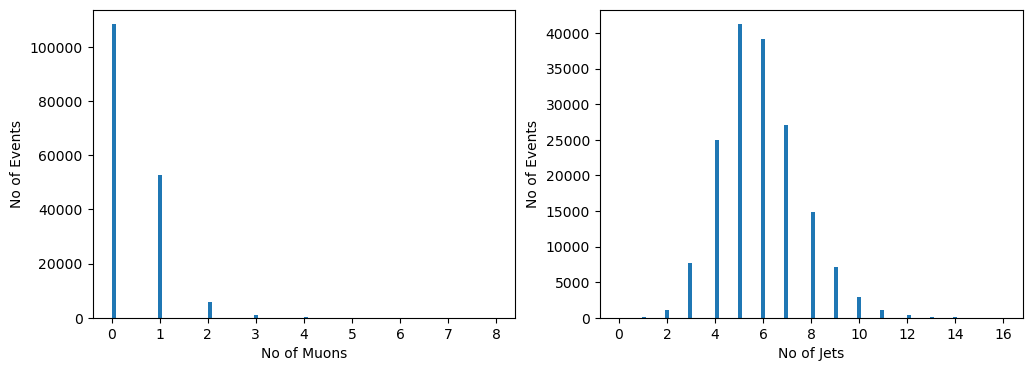

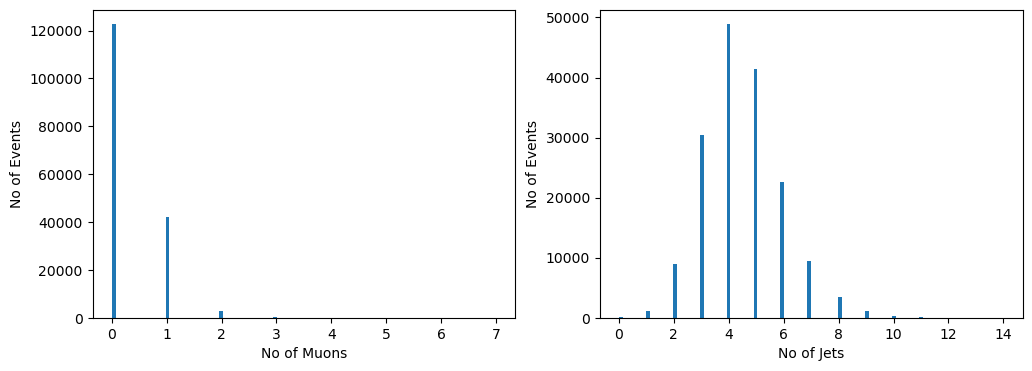

In [26]:
#Simple Muon and Jet cuts 
muon_cut = muon_pt > 20 
jet_cut = jet_pt > 20 

cuts = [0, 10, 15, 20, 30]
for cut in cuts: 
    muon_cut = muon_pt > cut 
    jet_cut = jet_pt > cut
    
    muon_pt_cut = muon_pt[muon_cut]
    jet_pt_cut = jet_pt[jet_cut]

    nmuon = ak.num(muon_pt_cut)
    njet = ak.num(jet_pt_cut)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(nmuon, bins=100);
    plt.xlabel("No of Muons")
    plt.ylabel("No of Events")
    plt.subplot(1,2,2)
    plt.hist(njet,bins=100);
    plt.xlabel("No of Jets")
    plt.ylabel("No of Events")

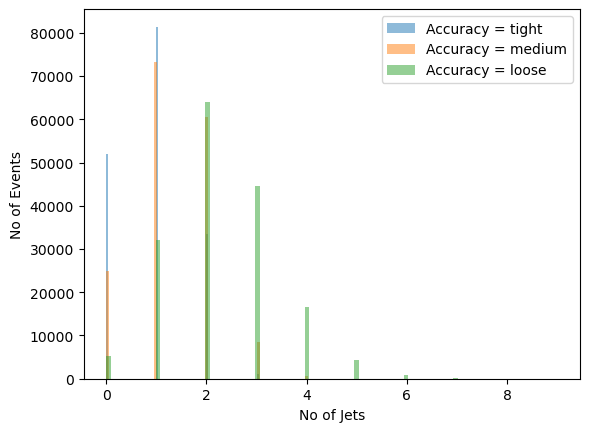

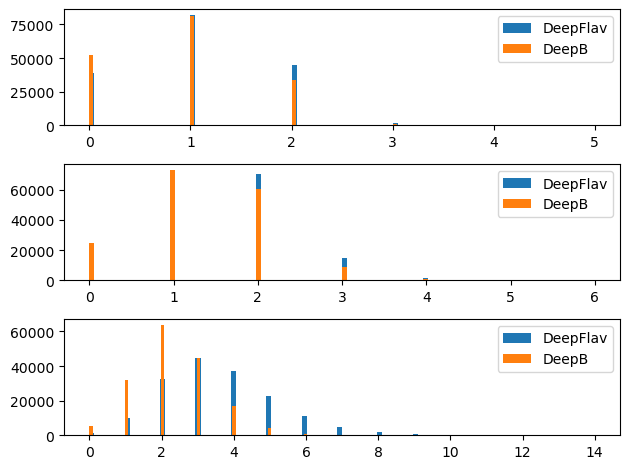

In [55]:
#btag_cuts
'''Values: 
Loose (10% misidentification rate): Jet_btagDeepB > 0.1918 , Jet_btagDeepFlavB > 0.0480
Medium (1% misidentification rate): Jet_btagDeepB > 0.5847, Jet_btagDeepFlavB > 0.2489
Tight (0.1% misidentification rate): Jet_btagDeepB > 0.8767, Jet_btagDeepFlavB > 0.6377
'''
def give_btag_cuts(choice, accuracy):
    '''
    choice = "DeepB" or "DeepFlav" 
    accuracy = "loose" "medium" or "tight" 
    '''
    if (choice == "DeepB") & (accuracy == "tight") : return jet_btagB > 0.8767
    if (choice == "DeepB") & (accuracy == "medium"): return jet_btagB > 0.5847
    if (choice == "DeepB") & (accuracy == "loose"): return jet_btagB > 0.1918

    if choice == "DeepFlav":
        if accuracy == "tight": return jet_btagFlavB > 0.6377
        if accuracy == "medium": return jet_btagFlavB > 0.2489
        if accuracy == "loose": return jet_btagFlavB > 0.0480

jet_btag_tight = jet_pt[give_btag_cuts("DeepB","tight")]
jet_btag_medium = jet_pt[give_btag_cuts("DeepB","medium")]
jet_btag_loose = jet_pt[give_btag_cuts("DeepB","loose")]

njet_btag_tight = ak.num(jet_btag_tight)
njet_btag_medium = ak.num(jet_btag_medium)
njet_btag_loose = ak.num(jet_btag_loose)

#Comparision of btagging loose, medium and tight
edgecolors = ['red', 'orange' , 'yellow']
all_njets = [njet_btag_tight, njet_btag_medium, njet_btag_loose]
names = ["tight", "medium", "loose"]
for all, name in zip(all_njets,names): 
    plt.hist(all, bins = 100, alpha = 0.5, label = f"Accuracy = {name}")
    plt.legend()
plt.xlabel("No of Jets")
plt.ylabel("No of Events")
plt.show()

#Comparison of the two different btagging 
jet_btagF_tight = jet_pt[give_btag_cuts("DeepFlav","tight")]
jet_btagF_medium = jet_pt[give_btag_cuts("DeepFlav","medium")]
jet_btagF_loose = jet_pt[give_btag_cuts("DeepFlav","loose")]

njet_btagF_tight = ak.num(jet_btagF_tight)
njet_btagF_medium = ak.num(jet_btagF_medium)
njet_btagF_loose = ak.num(jet_btagF_loose)

plt.subplot(3, 1, 1)
plt.hist(njet_btagF_tight, bins = 100,label= "DeepFlav");
plt.hist(njet_btag_tight, bins=100, label = "DeepB");
plt.legend()

plt.subplot(3,1,2)
plt.hist(njet_btagF_medium, bins = 100, label = "DeepFlav");
plt.hist(njet_btag_medium, bins=100, label = "DeepB");
plt.legend()

plt.subplot(3,1,3)
plt.hist(njet_btagF_loose, bins = 100, label = "DeepFlav");
plt.hist(njet_btag_loose, bins=100, label = "DeepB");
plt.legend()

plt.tight_layout()

In [ ]:
#Mixing b_tag and muon_cuts